<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/Two_moon_meanteacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

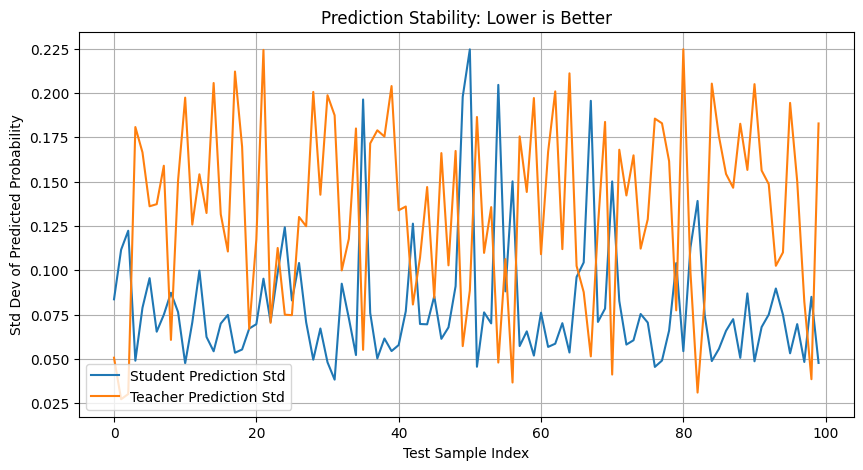

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Generate dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = X.astype(np.float32)
y = y.astype(np.int64)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

# Simple MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

# Initialize student and teacher
student = MLP()
teacher = MLP()
teacher.load_state_dict(student.state_dict())  # sync with student initially

# Optimizer
optimizer = torch.optim.Adam(student.parameters(), lr=0.01)

# EMA update function
def update_ema(student, teacher, alpha=0.99):
    for t_param, s_param in zip(teacher.parameters(), student.parameters()):
        t_param.data = alpha * t_param.data + (1 - alpha) * s_param.data

# Train student & update teacher
student_preds = []
teacher_preds = []

for epoch in range(30):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = student(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()
        update_ema(student, teacher)

    with torch.no_grad():
        student_preds.append(torch.softmax(student(X_test_tensor), dim=1)[:, 1].numpy())
        teacher_preds.append(torch.softmax(teacher(X_test_tensor), dim=1)[:, 1].numpy())

# Convert to arrays
student_preds = np.stack(student_preds)
teacher_preds = np.stack(teacher_preds)

# Plot stability (std dev of predictions)
plt.figure(figsize=(10, 5))
plt.plot(np.std(student_preds, axis=0), label='Student Prediction Std')
plt.plot(np.std(teacher_preds, axis=0), label='Teacher Prediction Std')
plt.title("Prediction Stability: Lower is Better")
plt.xlabel("Test Sample Index")
plt.ylabel("Std Dev of Predicted Probability")
plt.legend()
plt.grid(True)
plt.show()


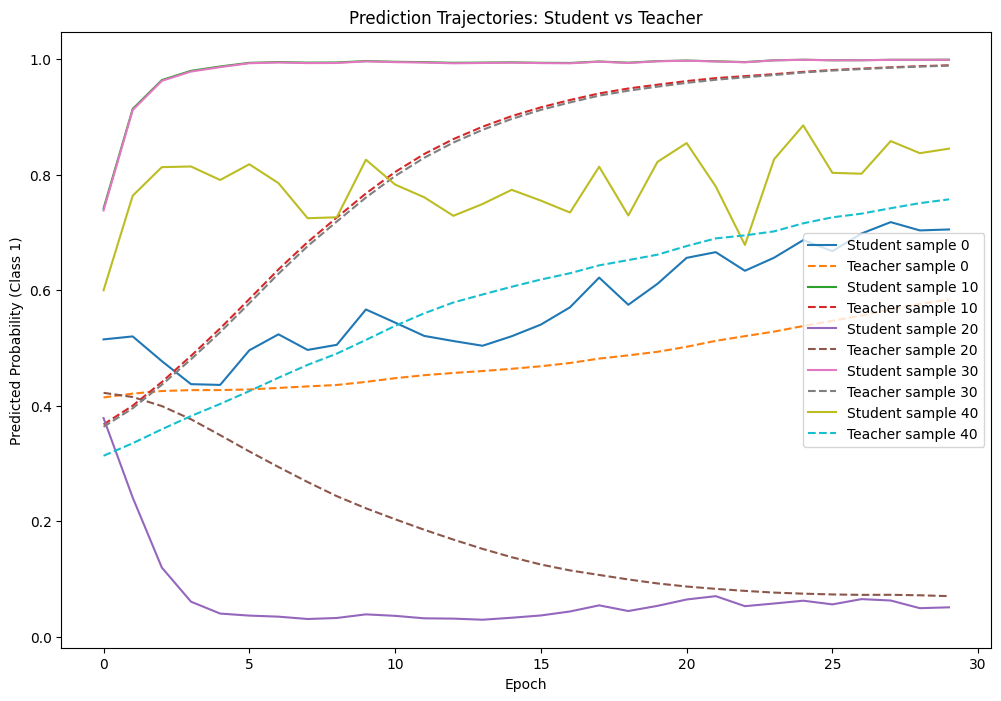

    Sample  Student Mean  Student Std  Teacher Mean  Teacher Std
0        0      0.576090     0.083629      0.480031     0.050690
1        1      0.374460     0.111617      0.367813     0.027251
2        2      0.464904     0.122327      0.415998     0.030169
3        3      0.978676     0.048995      0.823400     0.180818
4        4      0.937110     0.078846      0.740255     0.166555
..     ...           ...          ...           ...          ...
95      95      0.970558     0.053153      0.774480     0.194461
96      96      0.029291     0.069636      0.158439     0.150264
97      97      0.690016     0.048276      0.543810     0.082298
98      98      0.269346     0.085021      0.340489     0.038537
99      99      0.979449     0.047742      0.822103     0.182858

[100 rows x 5 columns]

Summary for first 10 samples:
   Sample  Student Mean  Student Std  Teacher Mean  Teacher Std
0       0      0.576090     0.083629      0.480031     0.050690
1       1      0.374460     0.111617 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming teacher_preds and student_preds are numpy arrays with shape (epochs, num_samples)

# Plot trajectories for a subset of samples
samples_to_plot = [0, 10, 20, 30, 40]

plt.figure(figsize=(12, 8))
for idx in samples_to_plot:
    plt.plot(student_preds[:, idx], label=f'Student sample {idx}')
    plt.plot(teacher_preds[:, idx], label=f'Teacher sample {idx}', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Predicted Probability (Class 1)')
plt.title('Prediction Trajectories: Student vs Teacher')
plt.legend()
plt.show()


# Summary stats per sample at end of training
summary = []
num_samples = teacher_preds.shape[1]
for i in range(num_samples):
    student_mean = np.mean(student_preds[:, i])
    student_std = np.std(student_preds[:, i])
    teacher_mean = np.mean(teacher_preds[:, i])
    teacher_std = np.std(teacher_preds[:, i])
    summary.append({
        "Sample": i,
        "Student Mean": student_mean,
        "Student Std": student_std,
        "Teacher Mean": teacher_mean,
        "Teacher Std": teacher_std,
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

# Optional: display only a few rows
print("\nSummary for first 10 samples:")
print(df_summary.head(10))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 1. Create two moons dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 2. Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

student = SimpleMLP().to(device)
teacher = SimpleMLP().to(device)
teacher.load_state_dict(student.state_dict())  # initialize teacher same as student
teacher.eval()

optimizer = optim.Adam(student.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

ema_decay = 0.99

# 3. Training loop with Mean Teacher EMA update & store predictions
student_preds_over_epochs = []
teacher_preds_over_epochs = []

epochs = 50
for epoch in range(epochs):
    student.train()
    optimizer.zero_grad()

    outputs = student(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()

    # EMA update for teacher
    with torch.no_grad():
        for param_student, param_teacher in zip(student.parameters(), teacher.parameters()):
            param_teacher.data.mul_(ema_decay).add_(param_student.data * (1 - ema_decay))

    # Store predictions on test set at current epoch (probabilities)
    student.eval()
    teacher.eval()
    with torch.no_grad():
        student_logits = student(X_test.to(device))
        teacher_logits = teacher(X_test.to(device))

        student_probs = F.softmax(student_logits, dim=1).cpu().numpy()[:, 1]  # prob class 1
        teacher_probs = F.softmax(teacher_logits, dim=1).cpu().numpy()[:, 1]

    student_preds_over_epochs.append(student_probs)
    teacher_preds_over_epochs.append(teacher_probs)

# 4. Prepare final predictions dataframe
student_final_preds = (student_preds_over_epochs[-1] > 0.5).astype(int)
teacher_final_preds = (teacher_preds_over_epochs[-1] > 0.5).astype(int)

df = pd.DataFrame({
    "Sample": np.arange(len(y_test)),
    "True Label": y_test.numpy(),
    "Student Pred (final)": student_final_preds,
    "Teacher Pred (final)": teacher_final_preds,
    "Student Prob (final)": student_preds_over_epochs[-1],
    "Teacher Prob (final)": teacher_preds_over_epochs[-1],
})

print(df.head(20))

# 5. (Optional) Plot final decision boundary of student and teacher here if you want


    Sample  True Label  Student Pred (final)  Teacher Pred (final)  \
0        0           1                     1                     1   
1        1           1                     1                     1   
2        2           0                     1                     1   
3        3           0                     0                     1   
4        4           0                     0                     0   
5        5           1                     1                     0   
6        6           1                     1                     1   
7        7           0                     0                     0   
8        8           1                     1                     1   
9        9           1                     1                     1   
10      10           0                     0                     0   
11      11           1                     1                     1   
12      12           0                     0                     0   
13      13          

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


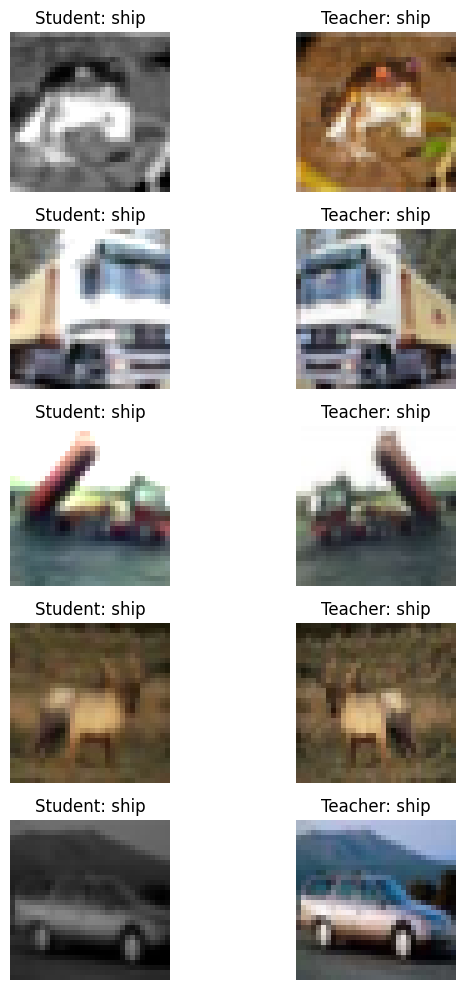

Ground truth labels:  ['frog', 'truck', 'truck', 'deer', 'automobile']
Student predictions:  ['ship', 'ship', 'ship', 'ship', 'ship']
Teacher predictions:  ['ship', 'ship', 'ship', 'ship', 'ship']


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define stronger (student) and weaker (teacher) augmentations
student_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
])

teacher_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])

# Load raw CIFAR-10 without transform
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
class_names = cifar10.classes

# Select a few samples
num_samples = 5
images, labels = zip(*[cifar10[i] for i in range(num_samples)])

# Apply transforms
student_images = [student_transform(img) for img in images]
teacher_images = [teacher_transform(img) for img in images]

# Stack and move to device
student_batch = torch.stack(student_images).to(device)
teacher_batch = torch.stack(teacher_images).to(device)

# Simple ResNet18 model adapted for CIFAR-10
class ResNet18CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Instantiate model (randomly initialized)
model = ResNet18CIFAR10().to(device)
model.eval()

# Get predictions
with torch.no_grad():
    preds_student = model(student_batch).argmax(dim=1)
    preds_teacher = model(teacher_batch).argmax(dim=1)

# Plot both views with predictions
fig, axes = plt.subplots(num_samples, 2, figsize=(7, 10))
for i in range(num_samples):
    student_np = student_batch[i].cpu().permute(1, 2, 0).numpy()
    teacher_np = teacher_batch[i].cpu().permute(1, 2, 0).numpy()

    axes[i, 0].imshow(student_np)
    axes[i, 0].set_title(f"Student: {class_names[preds_student[i]]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(teacher_np)
    axes[i, 1].set_title(f"Teacher: {class_names[preds_teacher[i]]}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Print original and predicted labels
print("Ground truth labels: ", [class_names[l] for l in labels])
print("Student predictions: ", [class_names[p] for p in preds_student])
print("Teacher predictions: ", [class_names[p] for p in preds_teacher])

